<a href="https://colab.research.google.com/github/engrvitalis/Data-Science/blob/main/Hospital_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# !pip install pymongo

# Hospital Bed Occupancy Rate (BOR) Forecasting Analysis

This analysis is a time-series forecasting project aimed at predicting a hospital's Bed Occupancy Rate (BOR) using machine learning. The primary goal is to provide a data-driven tool for hospital administrators to anticipate future bed usage, which can help in resource management, operational planning, and improving patient care.

**1. Data Preparation and Feature Engineering.**

In [52]:
from pprint import PrettyPrinter
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import plotly.express as px
import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

The analysis begins by importing the BOR dataset from the Excel file, BOR.xlsx.

In [53]:
df = pd.read_excel("/content/BOR.xlsx")
df.head()

,Date,BOR (%)
0,2020-01-01,72
1,2020-02-01,68
2,2020-03-01,65
3,2020-04-01,67
4,2020-05-01,70


The "Date" column is set as the DataFrame's index. Also, a critical step for time series analysis is converting the timezone from Coordinated Universal Time (UTC) to a specific, local time zone, in this case, Africa/Lagos. This ensures the analysis accurately reflects the local timeline of events.

In [55]:
df = df.set_index("Date")
df.index = df.index.tz_localize("UTC").tz_convert("Africa/Lagos")

A new feature, BOR(%).L1, is created by "lagging" the BOR column by one period. This means that for any given month, this new column will contain the BOR value from the previous month. This lagged feature is the core predictor in the model, as it assumes that the previous month's BOR is a strong indicator of the current month's BOR.

In [56]:
df["BOR(%).L1"] = df["BOR (%)"].shift(1)
df.head()

,BOR (%),BOR(%).L1
Date,,
2020-01-01 01:00:00+01:00,72,NaN
2020-02-01 01:00:00+01:00,68,72.0
2020-03-01 01:00:00+01:00,65,68.0
2020-04-01 01:00:00+01:00,67,65.0
2020-05-01 01:00:00+01:00,70,67.0


Finally, any rows with missing values (the first row, which now has no previous month's BOR) are removed to ensure a clean dataset for the model.

In [57]:
df.dropna(inplace=True)
df.head()

,BOR (%),BOR(%).L1
Date,,
2020-02-01 01:00:00+01:00,68,72.0
2020-03-01 01:00:00+01:00,65,68.0
2020-04-01 01:00:00+01:00,67,65.0
2020-05-01 01:00:00+01:00,70,67.0
2020-06-01 01:00:00+01:00,75,70.0


**2. Exploratory Data Analysis (EDA)**

A box plot is generated to visualize the distribution of the BOR (%) data. This helps identify the median, quartiles, and any outliers in the bed occupancy rate.

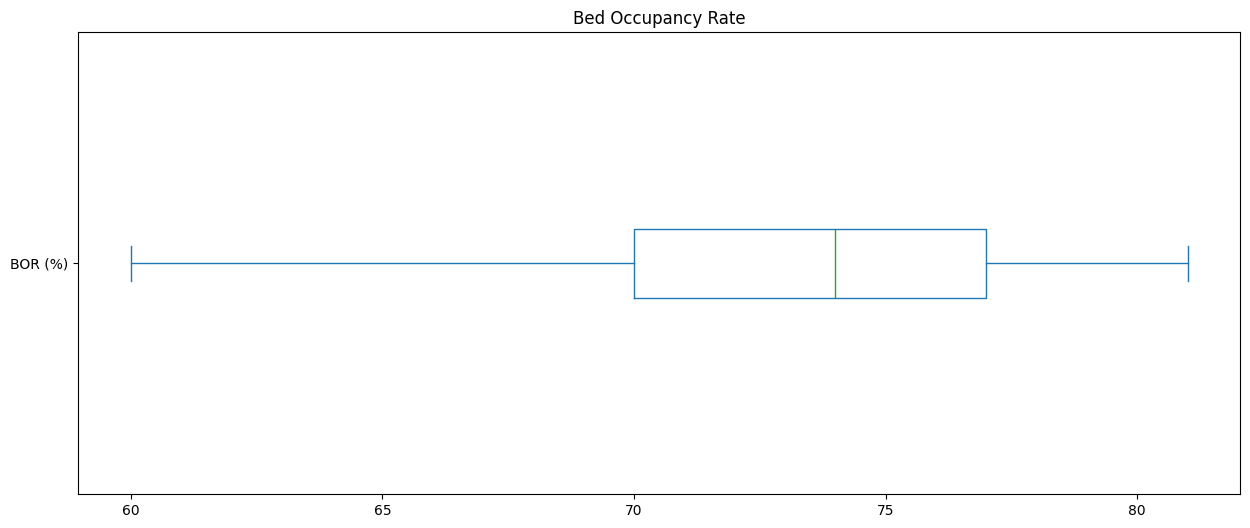

In [60]:
fig, ax = plt.subplots(figsize=(15, 6))
df["BOR (%)"].plot(kind="box", title="Bed Occupancy Rate", vert=False, ax=ax)
plt.show()

A time series plot is created to show how the BOR changes over time. This is a crucial step for any time series analysis, as it reveals trends, seasonality, and other patterns.

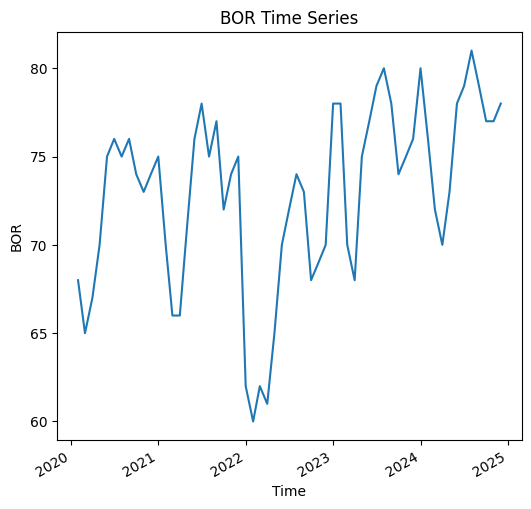

In [62]:
fig, ax = plt.subplots(figsize=(6, 6))
df["BOR (%)"].plot(xlabel="Time", ylabel="BOR", title="BOR Time Series", ax=ax)
plt.show()

A rolling mean plot is used to smooth out short-term fluctuations and highlight the underlying trend in the data. The plot uses a rolling window of 10 periods (10 months) to calculate the mean.

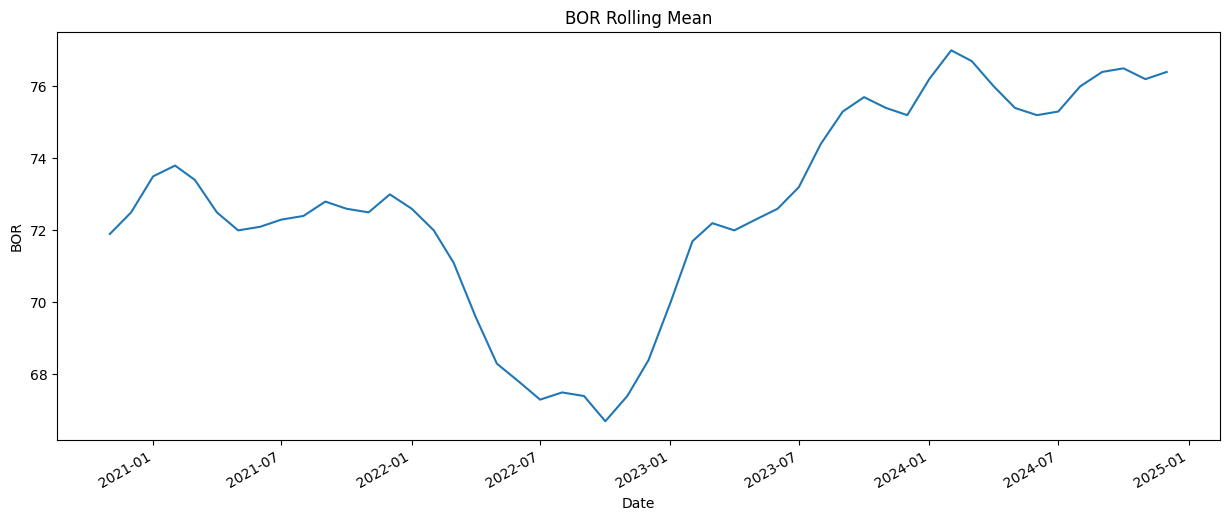

In [77]:
fig, ax = plt.subplots(figsize=(15, 6))
df["BOR (%)"].rolling(10).mean().plot(ax=ax, ylabel="BOR", title="BOR Rolling Mean");


The correlation between the current BOR and the previous month's BOR (BOR(%).L1) is calculated (0.74). A scatter plot is also created to visualize this relationship, with a red dashed line representing a perfect positive correlation. This confirms the strength of the relationship between the two variables, justifying the use of the lagged feature for prediction.

In [78]:
df.corr()

,BOR (%),BOR(%).L1
BOR (%),1.000000,0.743929
BOR(%).L1,0.743929,1.000000


Text(0.5, 1.0, 'BOR(%) Autocorrelation')

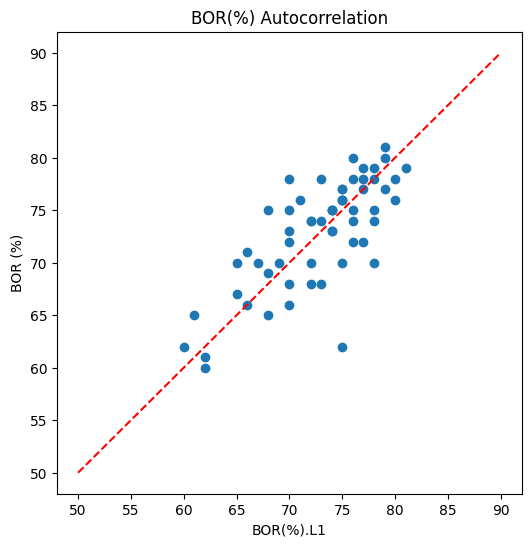

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df["BOR(%).L1"], y=df["BOR (%)"])
ax.plot([50, 90], [50, 90], linestyle="--", color="red")
plt.xlabel("BOR(%).L1")
plt.ylabel("BOR (%)")
plt.title("BOR(%) Autocorrelation")

**3. Model Training and Evaluation**

The dataset is split into a training set and a testing set. The training set, which contains 80% of the data, is used to teach the model the relationship between the variables. The remaining 20% is the testing set, used to evaluate how well the model performs on new, unseen data.

In [93]:
target = "BOR (%)"
y = df[target]
X = df.drop(columns=target)

In [97]:
cutoff = int(len(X) * 0.8)

X_train, y_train = X.iloc[: cutoff], y.iloc[: cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

A simple baseline model is established by using the mean of the training data as the prediction for all values in the training set. The Mean Absolute Error (MAE) is calculated for this baseline to provide the benchmark (4.22) for the machine learning model's performance.

In [103]:
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean BOR:", round(y_train.mean(),2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean BOR: 71.96
Baseline MAE: 4.22


A LinearRegression model is trained using the training data. The model learns the best-fit line to predict the current BOR based on the lagged BOR feature.

In [100]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

The MAE is calculated for both the training (2.74) and test (2.52) sets to assess the model's accuracy. The low test MAE indicates that the model is making accurate predictions on unseen data and is not overfitting to the training data.

In [104]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))

print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 2.74
Test MAE: 2.52


The final output of the analysis is a linear equation that can be used for forecasting. For example, the result BOR = 21.05 + 0.69 * BOR(%).L1 means that the predicted BOR is calculated by taking 69% of the previous month's BOR and adding an intercept of 21.05.

In [112]:
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)

print(f"BOR = {intercept} + {coefficient[0]} * BOR(%).L1")

BOR = 20.26 + 0.72 * BOR(%).L1


In [114]:
df_pred_test = pd.DataFrame(
    {
    "y_test": y_test,
    "y_pred": model.predict(X_test)
    }
)

df_pred_test.head()

,y_test,y_pred
Date,,
2024-01-01 01:00:00+01:00,80,74.926333
2024-02-01 01:00:00+01:00,76,77.803398
2024-03-01 01:00:00+01:00,72,74.926333
2024-04-01 01:00:00+01:00,70,72.049268
2024-05-01 01:00:00+01:00,73,70.610736


A line plot is generated to visually compare the model's predictions (y_pred) against the actual BOR values (y_test) on the test set. This visualization helps to confirm the model's accuracy and stability over time.

In [116]:
fig = px.line(df_pred_test, labels={"values": "BOR (%)"})
fig.show()

**4. Conclusion**

In conclusion, this data analysis effectively demonstrates the use of a simple linear regression model for forecasting hospital Bed Occupancy Rate (BOR). By using the previous month's BOR as a key predictor, the model achieved a low Mean Absolute Error (MAE) on unseen data, indicating strong predictive performance.

The results of this analysis provide a valuable, data-driven framework for hospital administrators. The final model equation can be used to forecast future BOR, enabling more informed decisions regarding resource allocation, staff scheduling, and inventory management. This predictive capability allows the hospital to proactively optimize operations, ultimately leading to improved patient care and increased efficiency.